In [62]:
import torch
import non_local_boxes
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')   # in ordert to have unblurred pictures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_94579/1125151455.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')   # in ordert to have unblurred pictures


# Definitions

In [3]:
matrix_to_tensor = non_local_boxes.utils.matrix_to_tensor
tensor_to_matrix = non_local_boxes.utils.tensor_to_matrix

# Boxes as 2x2x2x2 tensors
PR = matrix_to_tensor(non_local_boxes.utils.PR)
PRprime = matrix_to_tensor(non_local_boxes.utils.PRprime)
SR = matrix_to_tensor(non_local_boxes.utils.SR)
I = matrix_to_tensor(non_local_boxes.utils.I)

n = non_local_boxes.evaluate.nb_columns
W_BS09 = non_local_boxes.utils.W_BS09(n)

def WinCHSH(P): return float(non_local_boxes.evaluate.h_flat(P))                    # P is a 2x2x2x2 tensor
def WinCHSHprime(P): return float(non_local_boxes.evaluate.h_prime_flat(P))         # P is a 2x2x2x2 tensor
def BoxProduct(W,P,Q): return non_local_boxes.evaluate.R_tensor(W,P,Q)[:,:,:,:,0]   # P,Q are is a 2x2x2x2 tensor

def Catalan_number(k):
    return int(math.factorial(2*(k-1))/(math.factorial(k)*math.factorial(k-1)))

P = PR
print(WinCHSH(P), WinCHSHprime(P))
for k in range(1,11):
    print(k, Catalan_number(k))

1.0 0.5
1 1
2 1
3 2
4 5
5 14
6 42
7 132
8 429
9 1430
10 4862


In [4]:
def Compute_Orbits(P, W, max_depth):
    Orbits = [[P]]  # each all_orbits[k] is a list, which is the orbit of depth k+1
    for k in range(max_depth):
          Orbits.append([])
          for l in range(k+1):
                for Q1 in Orbits[l]:
                      for Q2 in Orbits[k-l]:
                            Orbits[k+1].append( BoxProduct(W, Q1, Q2) )
    return Orbits

In [93]:
def Draw_Orbit(P, P1, P1name, P2, P2name, P3, P3name, W, max_depth):
    # P, P1, P2, P3 are 2x2x2x2 matrices

    # Draw the initial background triangle:
    x1, y1 = WinCHSHprime(P1), WinCHSH(P1)
    x2, y2 = WinCHSHprime(P2), WinCHSH(P2)
    x3, y3 = WinCHSHprime(P3), WinCHSH(P3)
    triangle = plt.Polygon(np.array([[x1, y1], [x2,y2], [x3, y3]]), color=hsv_to_rgb([0.475, 1, 0.9]))
    plt.gca().add_patch(triangle)

    BBLMTU_value = (3+math.sqrt(6))/6
    BBLMTU_rectangle = plt.Polygon(np.array([[0.5, 1.0], [0.5,BBLMTU_value], [1.5-BBLMTU_value, BBLMTU_value]]), color=hsv_to_rgb([0.475, 1, 0.5]))
    plt.gca().add_patch(BBLMTU_rectangle)

    # Check if our coordinate system is good, i.e. if projected points aren't aligned:
    if (x1 - x3)*(y2-y3)==(x2-x3)*(y1-y3):
            print("WARNING: Error in the coordinate system.")
            return None

    # Draw the orbit:
    Orbits = Compute_Orbits(P, W, max_depth)
    for k in range(len(Orbits)):
        color = hsv_to_rgb([k/(10*len(Orbits)), 1, 1])
        for Q in Orbits[k]:  # Q is a tensor
            # Compute the abscissa and the ordinate:
            x = WinCHSHprime(Q)
            y = WinCHSH(Q)
            plt.plot(x, y, 'o', markersize=4, color=color)
    
    plt.text(WinCHSHprime(P), WinCHSH(P), "  ← starting box $\mathbf{P}$", horizontalalignment='left', verticalalignment = 'center')
    plt.text(x1+0.001, y1, P1name, horizontalalignment='center',weight="bold")
    plt.text(x2, y2+0.007, P2name, verticalalignment='center',weight="bold")
    plt.text(x3, y3-0.007, P3name, verticalalignment='center',weight="bold")
    plt.title("Orbit of a box $\mathbf{P}$ until depth $k=$"+str(max_depth))
    plt.show()


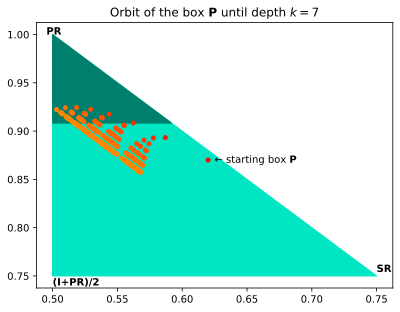

In [95]:
alpha = 0.5
beta = 0.48
P = alpha*PR + beta*SR + (1-alpha-beta)*I

Orbits = Draw_Orbit(
    P = P,
    P1 = PR,
    P1name = "PR",
    P2 = SR,
    P2name = "SR",
    P3 = (I+PR)/2,
    P3name = "(I+PR)/2",
    W = W_BS09,
    max_depth = 7
)